## Import das bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from PIL import Image

import os
from os import listdir
from tqdm import tqdm
import shutil
import cv2

from keras import Input
from keras import Model
from keras.models import Sequential
from keras.utils import np_utils, to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, LearningRateScheduler

from math import *
import zipfile
from tensorflow.keras.models import load_model


## Copiando apenas imagens para diretório breakhis_imgs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/breaKHis.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
size = 224

In [ ]:
os.mkdir('breakhis_imgs')
os.mkdir('./breakhis_imgs/benign')
os.mkdir('./breakhis_imgs/malignant')

In [ ]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

In [ ]:
files_benign = getListOfFiles('/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):

        shutil.copy(f,'breakhis_imgs/benign')
files_malignant = getListOfFiles('/content/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):

        shutil.copy(f,'breakhis_imgs/malignant')

In [ ]:
data_path = pathlib.Path(r'/content/breakhis_imgs')

# glob all 'jpg' image files
img_path = list(data_path.glob('**/*.png'))

# split label names from file directory
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

In [ ]:
pd_img_path = pd.Series(img_path, name='PATH').astype(str)
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)

img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

img_df = img_df.sample(frac = 1).reset_index(drop=True)


img_df.head()

,PATH,LABELS
0,/content/breakhis_imgs/malignant/SOB_M_LC-14-1...,malignant
1,/content/breakhis_imgs/malignant/SOB_M_DC-14-5...,malignant
2,/content/breakhis_imgs/benign/SOB_B_PT-14-2199...,benign
3,/content/breakhis_imgs/malignant/SOB_M_MC-14-1...,malignant
4,/content/breakhis_imgs/malignant/SOB_M_DC-14-2...,malignant


In [ ]:
img_df['LABELS'].value_counts(ascending=True)


benign       2480
malignant    5429
Name: LABELS, dtype: int64

In [ ]:
train_dataset, test_dataset = train_test_split(img_df, train_size=0.8, shuffle=True, stratify=img_df['LABELS'])
print("Number of train data:", train_dataset.shape[0])
print("Number of test data:", test_dataset.shape[0])

Number of train data: 6327
Number of test data: 1582


## Unsampling Data

<Axes: xlabel='LABELS', ylabel='count'>

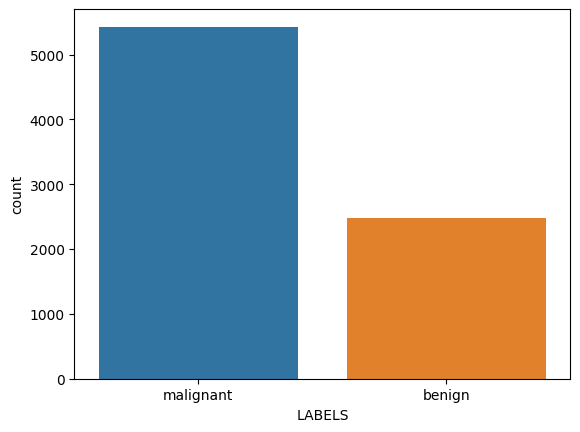

In [ ]:
# making a plot to see data distribution
# sns.figure()
sns.countplot(x=img_df['LABELS'], data=train_dataset)

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Separar os exemplos das classes minoritária e majoritária
class_minority = train_dataset[train_dataset['LABELS'] == 'benign']
class_majority = train_dataset[train_dataset['LABELS'] == 'malignant']

# Realizar undersampling na classe majoritária
class_majority_undersampled = resample(class_majority,
                                       replace=False,    # Sem substituição
                                       n_samples=len(class_minority),  # Número de amostras igual à classe minoritária
                                       random_state=42)  # Para reprodutibilidade

# Concatenar as classes minoritária e majoritária undersampled
undersampled_dataset = pd.concat([class_minority, class_majority_undersampled])

# O conjunto de dados 'undersampled_dataset' agora contém um número balanceado de amostras de cada classe


In [ ]:
undersampled_dataset.count()

PATH      3968
LABELS    3968
dtype: int64

<Axes: xlabel='LABELS', ylabel='count'>

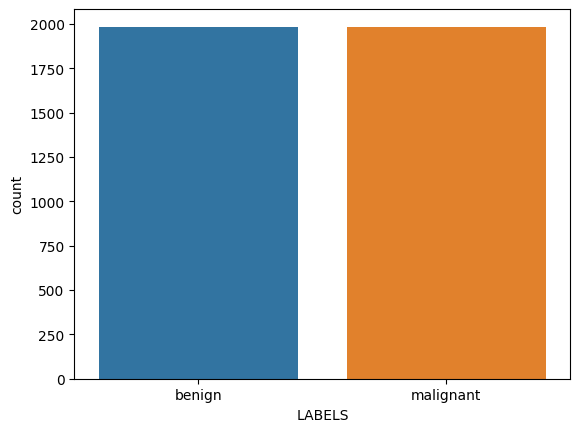

In [ ]:
# making a plot to see data distribution
# sns.figure()
sns.countplot(x=undersampled_dataset['LABELS'], data=undersampled_dataset)

## Data Generator

In [ ]:
img_size = (224, 224)
batch_size = 128

In [ ]:
gerador_treinamento = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

dataset_treinamento = gerador_treinamento.flow_from_dataframe(train_dataset,
                                                              x_col='PATH', y_col='LABELS',
                                                              target_size = (224, 224),
                                                              batch_size = batch_size,
                                                              class_mode = 'binary',
                                                              subset='training',
                                                              shuffle = True)

validation_generator = gerador_treinamento.flow_from_dataframe(
    train_dataset,
    x_col='PATH', y_col='LABELS',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 5062 validated image filenames belonging to 2 classes.
Found 1265 validated image filenames belonging to 2 classes.


In [ ]:
dataset_treinamento.class_indices

{'benign': 0, 'malignant': 1}

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Carregar modelo pré-treinado no ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Congelar as camadas do modelo pré-treinado
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation = 'sigmoid'))


# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Exibir resumo do modelo
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               13

In [ ]:

# Treinar o modelo
history = model.fit(
    dataset_treinamento,
    steps_per_epoch=dataset_treinamento.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/20
39/39 [==============================] - 220s 5s/step - loss: 0.9813 - accuracy: 0.6544 - precision: 0.7391 - recall: 0.7681 - auc: 0.6204 - val_loss: 0.5995 - val_accuracy: 0.6797 - val_precision: 0.8081 - val_recall: 0.7035 - val_auc: 0.7386
Epoch 2/20
39/39 [==============================] - 161s 4s/step - loss: 0.5832 - accuracy: 0.7418 - precision: 0.7900 - recall: 0.8480 - auc: 0.7704 - val_loss: 0.5830 - val_accuracy: 0.7448 - val_precision: 0.9130 - val_recall: 0.6976 - val_auc: 0.8524
Epoch 3/20
39/39 [==============================] - 168s 4s/step - loss: 0.5209 - accuracy: 0.7750 - precision: 0.8193 - recall: 0.8619 - auc: 0.8187 - val_loss: 0.5163 - val_accuracy: 0.8090 - val_precision: 0.8441 - val_recall: 0.8866 - val_auc: 0.8569
Epoch 4/20
39/39 [==============================] - 155s 4s/step - loss: 0.4604 - accuracy: 0.8010 - precision: 0.8361 - recall: 0.8834 - auc: 0.8477 - val_loss: 0.4945 - val_accuracy: 0.8290 - val_precision: 0.8430 - val_recall: 0.922

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1/255)
dataset_teste = gerador_teste.flow_from_dataframe(test_dataset,
                                                  x_col='PATH', y_col='LABELS',
                                                  target_size = (224,224),
                                                  batch_size = 64,
                                                  class_mode = 'binary',
                                                  shuffle=False)

Found 1582 validated image filenames belonging to 2 classes.


25/25 [==============================] - 41s 1s/step
Classification Report:
               precision    recall  f1-score   support

      benign       0.88      0.69      0.77       496
   malignant       0.87      0.96      0.91      1086

    accuracy                           0.87      1582
   macro avg       0.88      0.82      0.84      1582
weighted avg       0.87      0.87      0.87      1582



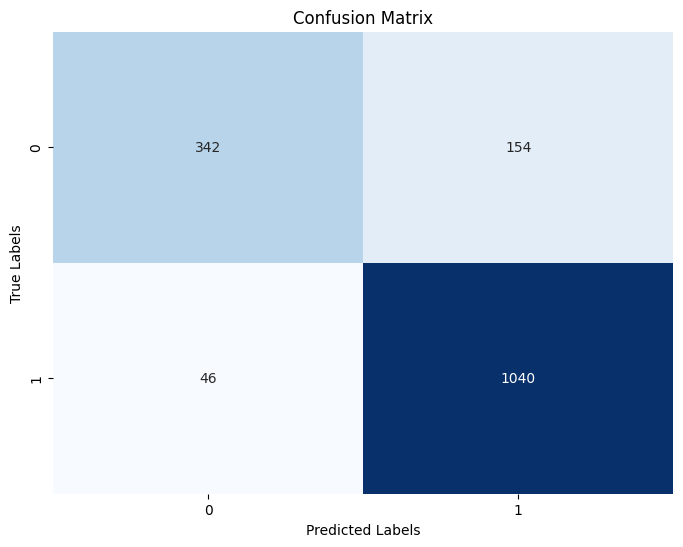

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prever as classes no conjunto de teste
test_predictions = model.predict(dataset_teste)

# Arredondar as previsões para obter classes binárias
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Extrair os rótulos reais do conjunto de teste
y_test = dataset_teste.labels

# Obter os nomes das classes
class_names = list(dataset_teste.class_indices.keys())

# Imprimir o relatório de classificação
report = classification_report(y_test, test_predictions_binary, target_names=class_names)
print("Classification Report:\n", report)

# Calcular a matriz de confusão
confusion = confusion_matrix(y_test, test_predictions_binary)

# Plotar a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



25/25 [==============================] - 22s 875ms/step


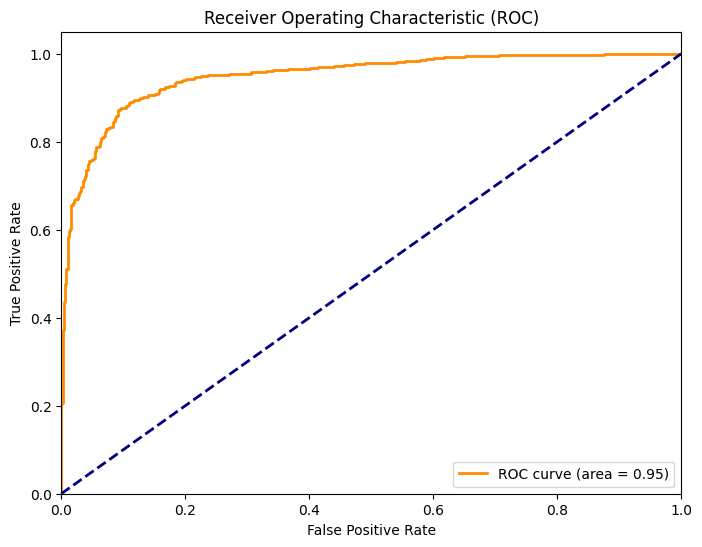

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prever as probabilidades das classes positivas
test_predictions = model.predict(dataset_teste)

# Extrair os rótulos reais do conjunto de teste
y_test = dataset_teste.labels

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)

# Calcular a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Salvar o modelo treinado
model.save('vgg16_BreaKHis_model2.h5')
